In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

In [17]:
# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

# return 5-fold CV train accuracy
def crossValidation(x, y):
    #split data for cross-validation
    xlist, ylist = getSplitData(x, y, 5)
    trainAcc = []
    for i in range(5):
        model = LogisticRegression()
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
        trainAcc.append(metrics.accuracy_score(ytest, model.predict(xtest)))
    model = LogisticRegression()
    model.fit(x, y)
    return model, np.mean(trainAcc)

In [18]:
#uncertainy sampling

def uncertainSample(model, xtest, ytest):
    predProb = model.predict_proba(xtest)
    predConf = [1-np.max(i) for i in predProb] # calculate confidence for new data
    p = np.argmax(predConf)
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

def uncertainTrain(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20)
    performance = []
    while len(xUnob) > 0:
        model, acc = crossValidation(xObs, yObs)
        performance.append(acc) #performance with cross-validation
        # append new samples
        xNew, yNew, xUnob, yUnob = uncertainSample(model, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return performance

In [19]:
# density sampling

def densitySample(model, xtrain, ytrain, xtest, ytest):
    density = []
    # calculate uncertainty for xtest
    sxx = sum(xtrain)**2-sum(xtrain)**2/len(xtrain)
    s = metrics.mean_squared_error(ytrain, model.predict(xtrain))
    var = [np.linalg.norm(np.array(s**2*(1/len(xtrain)+(i-np.mean(xtrain))**2/sxx))) for i in xtest]
    # calculate averaged similarity
    for i, x1 in enumerate(xtest):
        sim = [np.linalg.norm(x1-x2) for x2 in xtest]
        density.append(var[i] * np.mean(sim))
    p = np.argmax(var) # selects the greatest information density
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

def densityTrain(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 20) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(metrics.accuracy_score(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = densitySample(model, xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

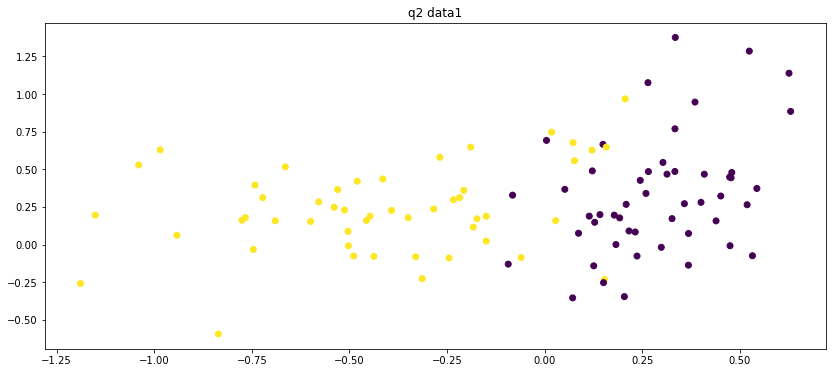

In [107]:
# generate dataset and plot
d1 = datasets.make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, class_sep=0.3,random_state=1)
plt.scatter(d1[0][:, 0], d1[0][:, 1],c=d1[1])
plt.title("q2 data1")
plt.show() 

In [20]:
# run simluation
uncertainAcc, densityAcc = [], []
for i in range(10):
    random.seed(i)
    print("in simulation", i)
    uncertainAcc.append(uncertainTrain(d1[0], d1[1]))
    a1, _ = densityTrain(d1[0], d1[1])
    densityAcc.append(a1)
    
# calculate mean and std for 10 simulation
uncertainMean = [np.mean(i) for i in np.transpose(np.array(uncertainAcc))]
uncertainStd = [np.std(i) for i in np.transpose(np.array(uncertainAcc))]

densityMean = [np.mean(i) for i in np.transpose(np.array(densityAcc))]
densityStd = [np.std(i) for i in np.transpose(np.array(densityAcc))]

in simulation 0
in simulation 1
in simulation 2
in simulation 3
in simulation 4
in simulation 5
in simulation 6
in simulation 7
in simulation 8
in simulation 9


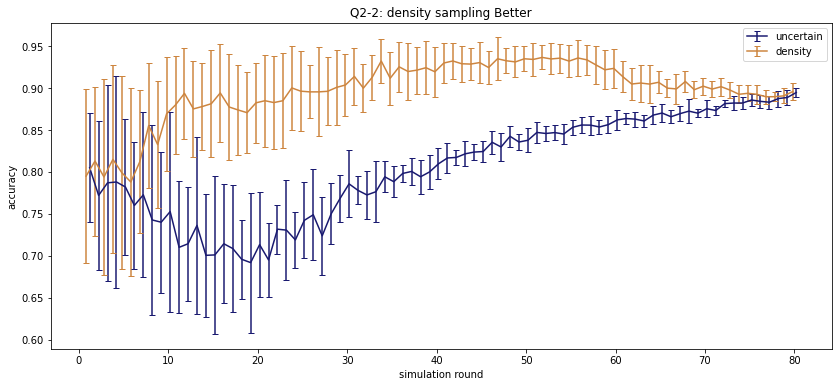

In [103]:
# plot the graph
xaxis = np.arange(len(uncertainMean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis+1.2, uncertainMean, yerr = uncertainStd,  label = 'uncertain', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis+0.8, densityMean, yerr = densityStd, label = 'density', color = 'peru', ecolor='peru',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Q2-2: density sampling Better")
plt.legend()
plt.show()

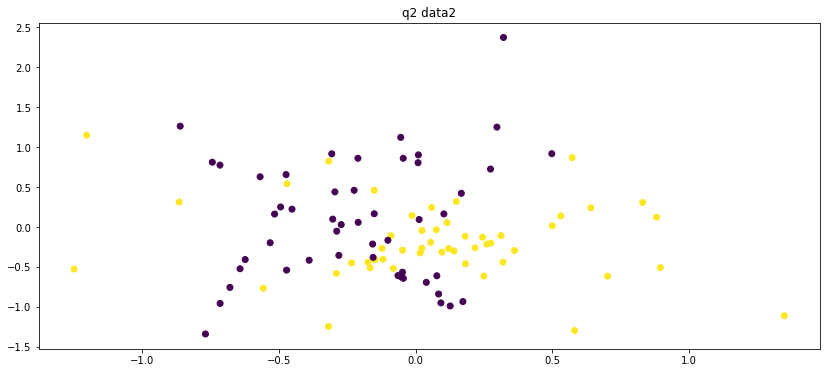

In [105]:
# generate dataset and plot
d2 = datasets.make_classification(n_features=2, n_redundant=0, n_clusters_per_class=2, class_sep=0.2,random_state=1)
plt.scatter(d2[0][:, 0], d2[0][:, 1],c=d2[1])
plt.title("q2 data2")
plt.show()

In [100]:
# run simluation
uncertainAcc2, densityAcc2 = [], []
for i in range(10):
    random.seed(i)
    print("uncertain round", i)
    uncertainAcc2.append(uncertainTrain(d2[0], d2[1]))

for i in range(10):
    random.seed(i)
    print("density round", i)
    a1, _ = densityTrain(d2[0], d2[1])
    densityAcc2.append(a1)
    
# calculate mean and std for 10 simulation
uncertainMean2 = [np.mean(i) for i in np.transpose(np.array(uncertainAcc2))]
uncertainStd2 = [np.std(i) for i in np.transpose(np.array(uncertainAcc2))]

densityMean2 = [np.mean(i) for i in np.transpose(np.array(densityAcc2))]
densityStd2 = [np.std(i) for i in np.transpose(np.array(densityAcc2))]

uncertain round 0
uncertain round 1
uncertain round 2
uncertain round 3
uncertain round 4
uncertain round 5
uncertain round 6
uncertain round 7
uncertain round 8
uncertain round 9
density round 0
density round 1
density round 2
density round 3
density round 4
density round 5
density round 6
density round 7
density round 8
density round 9


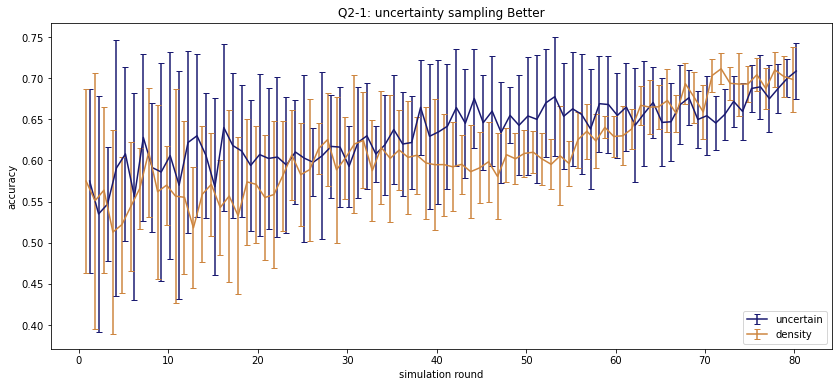

In [102]:
# plot the graph
xaxis = np.arange(len(uncertainMean2))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis+1.2, uncertainMean2, yerr = uncertainStd2,  label = 'uncertain', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(xaxis+0.8, densityMean2, yerr = densityStd2, label = 'density', color = 'peru', ecolor='peru',capsize=3)

plt.xlabel("simulation round")
plt.ylabel("accuracy")
plt.title("Q2-1: uncertainty sampling Better")
plt.legend()
plt.show()